In [5]:
from torch import nn , save , load
import torchvision
import torch
from torch.autograd import Variable
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [6]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
from torchvision import datasets, transforms

CIFAR_train = datasets.CIFAR10('dataTrain', train=True, download=True,
                       transform=transforms.ToTensor())

CIFAR_test = datasets.CIFAR10('dataTest', train=False, download=True, transform=
                            transforms.ToTensor())


print(CIFAR_train)
print('-----')
print(CIFAR_test)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataTrain
    Split: Train
    StandardTransform
Transform: ToTensor()
-----
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dataTest
    Split: Test
    StandardTransform
Transform: ToTensor()


In [8]:
class NN_model(nn.Module):
    def __init__(self,input_size,hidden1_size,hidden2_size,hidden3_size,output_size):
        super(NN_model,self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden1_size)
        self.fc2 = torch.nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = torch.nn.Linear(hidden2_size, hidden3_size)
        self.fc4 = torch.nn.Linear(hidden3_size, output_size)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        # out = self.softmax(out)
        return out

In [9]:
size_cifar = CIFAR_train[1][0].size()

input_size = size_cifar[0]*size_cifar[1]*size_cifar[2]
hidden1_size = 4096
hidden2_size = 2048
hidden3_size = 512
num_classes = 10

In [10]:
# Checking if working correctly or not
model = NN_model(input_size, hidden1_size,hidden2_size,hidden3_size, num_classes).to(device)
print(f"CIFAR example shape:{CIFAR_train[0][0].size()}")
X = torch.randn(70,3*32*32).to(device)
print(f"Model output for X in shape: {X.size()} is {model(X).shape}")
print(f"The final model:{model}")

CIFAR example shape:torch.Size([3, 32, 32])
Model output for X in shape: torch.Size([70, 3072]) is torch.Size([70, 10])
The final model:NN_model(
  (fc1): Linear(in_features=3072, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
)


In [75]:
num_epochs = 30
batch_size = 200
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate , weight_decay=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(dataset=CIFAR_train,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=CIFAR_test,batch_size=batch_size,shuffle=False)



In [79]:
n_total_steps = len(train_loader)
train_loss = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        images = images.reshape(images.shape[0], -1)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            train_loss.append(loss.item())

Epoch [1/2], Step [100/250], Loss: 1.8967
Epoch [1/2], Step [200/250], Loss: 1.9150
Epoch [2/2], Step [100/250], Loss: 1.9508
Epoch [2/2], Step [200/250], Loss: 1.9513


In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} from {num_samples} with accuracy"
            f" {float(num_correct) / float(num_samples) * 100:.2f}"
        )

    model.train()

In [ ]:
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Got 20789 from 50000 with accuracy 41.58
Got 4072 from 10000 with accuracy 40.72


<Axes: >

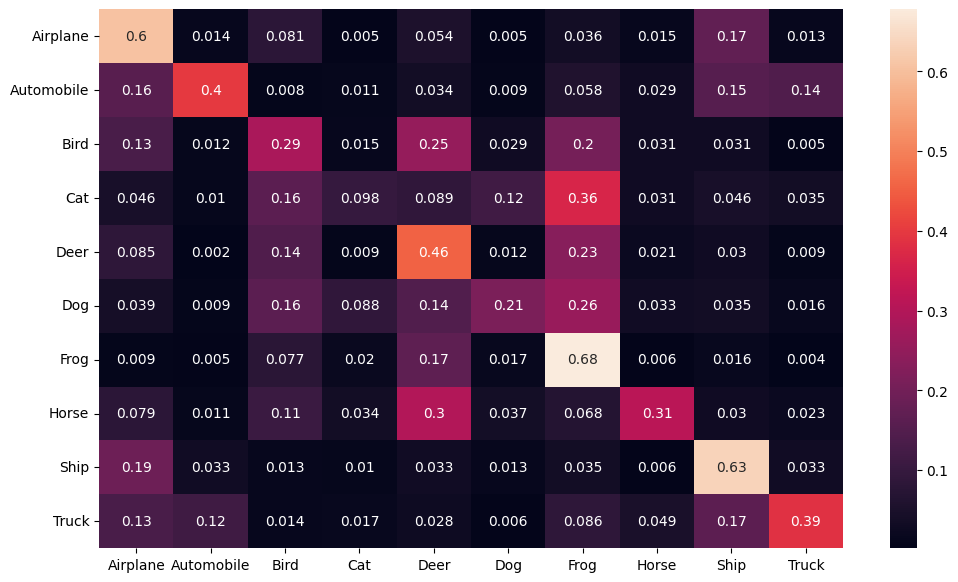

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():

  for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          inputs = inputs.reshape(inputs.shape[0], -1)

          output = model(inputs)

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # constant for classes
  classes = ('Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
        'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
! pip install scikit-learn


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix , classification_report
acc = accuracy_score(y_pred,y_true) * 100
report=classification_report(y_true, y_pred,target_names = classes)
print(f"Accuracy = {acc:.2f}%")
print("Classification Report: \n",report)

Accuracy = 40.72%
Classification Report: 
               precision    recall  f1-score   support

    Airplane       0.41      0.60      0.49      1000
  Automobile       0.65      0.40      0.50      1000
        Bird       0.27      0.29      0.28      1000
         Cat       0.32      0.10      0.15      1000
        Deer       0.29      0.46      0.36      1000
         Dog       0.47      0.21      0.29      1000
        Frog       0.34      0.68      0.45      1000
       Horse       0.59      0.31      0.41      1000
        Ship       0.48      0.63      0.55      1000
       Truck       0.58      0.39      0.46      1000

    accuracy                           0.41     10000
   macro avg       0.44      0.41      0.39     10000
weighted avg       0.44      0.41      0.39     10000

